In [1]:
using Lux#, Optimisers, Random, Statistics, Zygote
using NPZ
using JLD2
using CairoMakie
using PyCall

np = pyimport("numpy")

PyObject <module 'numpy' from '/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/__init__.py'>

In [2]:
nk = 100
nz = 20
nc = 2000
ncv = 1000

cicli = 20
epoche = 20000
div = 5

5

In [3]:
input = npzread("../files/train_in_emul_" * string(nc) * ".npy")
output = npzread("../files/train_pkz_emul_" * string(nc) * ".npy")
output = np.reshape(output, [nc,nk*nz])'

x = input
y = output

2000×2000 adjoint(::Matrix{Float64}) with eltype Float64:
 361.521     356.045     453.467     …  435.62      409.802     403.649
 269.802     265.245     345.399        330.481     309.11      304.116
 203.51      199.823     264.353        252.194     234.907     230.924
 156.519     153.554     205.324        195.481     181.564     178.389
 123.007     120.608     162.423        154.421     143.152     140.601
  98.6918     96.7294    130.892     …  124.322     115.099     113.023
  80.6774     79.0508    107.322        101.865      94.2215     92.5094
  67.0466     65.6808     89.3761        84.7893     78.3759     76.9452
  56.5263     55.3657     75.4647        71.5647     66.1198     64.9096
  48.259      47.2618     64.4976        61.1462     56.4735     55.4384
  41.6562     40.7908     55.7177    …   52.81       48.7606     47.8663
  36.3057     35.548      48.5905        46.0456     42.5054     41.7259
  31.9136     31.2449     42.7319        40.4871     37.3674     36.6825

In [4]:
# standardizzazione del trainig dataset (feature - min(features))/(max(features) - min(features))
min_in = minimum(x, dims=2)
max_in = maximum(x, dims=2)

min_out = minimum(y, dims=2)
max_out = maximum(y, dims=2)

x = (x .- min_in) ./ (max_in .- min_in)
y = (y .- min_out) ./ (max_out .- min_out)

2000×2000 Matrix{Float64}:
 0.231803  0.204158  0.696009  0.269413  …  0.605906  0.475559  0.444492
 0.228577  0.200582  0.692983  0.266027     0.601338  0.470051  0.439374
 0.225683  0.197545  0.690096  0.262944     0.597287  0.465334  0.434934
 0.223484  0.195281  0.687826  0.260587     0.594178  0.461767  0.431568
 0.221923  0.193674  0.686188  0.25891      0.591933  0.4592    0.429152
 0.220837  0.192545  0.685049  0.257746  …  0.59034   0.457367  0.427439
 0.220082  0.191743  0.684266  0.25694      0.589205  0.456043  0.426215
 0.219553  0.191162  0.683732  0.25638      0.588383  0.455064  0.425322
 0.219177  0.190729  0.683369  0.255987     0.587777  0.45432   0.424656
 0.218908  0.190399  0.683125  0.25571      0.587318  0.453739  0.424146
 0.218712  0.190141  0.682966  0.255514  …  0.586965  0.453271  0.423746
 0.21857   0.189934  0.682867  0.255376     0.586686  0.452884  0.423423
 0.218465  0.189764  0.682812  0.255279     0.586461  0.452557  0.423157
 ⋮                      

In [5]:
# carico lo stato allenato della rete

tstate = JLD2.load("../models/nn_$(cicli)-$(epoche)_$(div).jld2", "tstate")

# importo validation dataset

valid_in = npzread("../files/val_in_emul_" * string(ncv) * ".npy")
valid_in = (valid_in .- minimum(valid_in, dims=2)) ./ (maximum(valid_in, dims=2) .- minimum(valid_in, dims=2))
valid_out = npzread("../files/val_pkz_emul_" * string(ncv) * ".npy")
val_out = np.reshape(valid_out, [ncv,nk*nz])'

2000×1000 adjoint(::Matrix{Float64}) with eltype Float64:
 475.079     432.958     365.496     …  348.217     380.629      393.833
 363.125     328.145     272.957        258.991     285.295      296.059
 278.626     250.231     205.985        194.896     215.844      224.449
 216.782     193.858     158.469        149.662     166.334      173.202
 171.682     153.081     124.561        117.499     130.889      136.415
 138.455     123.209      99.9494    …   94.2097    105.104      109.606
 113.577     100.931      81.71          76.9787     85.9663      89.6839
  94.6143     83.9964     67.9064        63.953      71.468       74.5782
  79.9027     70.8846     57.2515        53.9064     60.2686      62.9027
  68.2981     60.5571     48.8778        46.0151     51.4623      53.7181
  59.0042     52.2949     42.1895    …   39.7147     44.4257      46.3769
  51.4575     45.5914     36.7696        34.6107     38.722       40.4249
  45.2529     40.0836     32.3204        30.4218     34.0388

In [6]:
# predizione con training dataset
dev_cpu = cpu_device()
pred_train_iniz = dev_cpu(Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_train_st = (pred_train_iniz .- minimum(pred_train_iniz, dims=2)) ./ (maximum(pred_train_iniz, dims=2) .- minimum(pred_train_iniz, dims=2))

# de-standardizzo la predizione standardizzata
pred_train_st = pred_train_st .* (max_out - min_out) .+ min_out

# de-standrdizzo la predizione iniziale
pred_train = pred_train_iniz .* (max_out - min_out) .+ min_out

2000×2000 Matrix{Float64}:
 361.183     355.951     453.79      …  435.613     409.723     403.972
 269.43      265.17      345.652        330.438     309.071     304.328
 203.354     199.714     264.43         252.066     234.728     231.063
 156.411     153.555     205.453        195.389     181.271     178.496
 122.903     120.593     162.512        154.323     143.045     140.65
  98.5581     96.6614    130.953     …  124.262     114.999     113.087
  80.6229     79.0471    107.504        101.845      94.158      92.5819
  66.9205     65.6593     89.4772        84.7476     78.396      76.9571
  56.4917     55.3699     75.5866        71.5227     66.0931     64.9798
  48.2105     47.2441     64.5557        61.1063     56.45       55.4883
  41.5784     40.7804     55.7633    …   52.7946     48.7548     47.8873
  36.2862     35.5536     48.6886        46.0167     42.5012     41.756
  31.8829     31.221      42.7897        40.4695     37.3165     36.7134
   ⋮                            

In [7]:
# predizione con validation dataset
pred_val_iniz = dev_cpu(Lux.apply(tstate.model, valid_in, tstate.parameters, tstate.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_val_st = (pred_val_iniz .- minimum(pred_val_iniz, dims=2)) ./ (maximum(pred_val_iniz, dims=2) .- minimum(pred_val_iniz, dims=2))

# de-standardizzo la predizione standardizzata
pred_val_st = pred_val_st .* (max_out - min_out) .+ min_out

# de-standrdizzo la predizione iniziale
pred_val = pred_val_iniz .* (max_out - min_out) .+ min_out

2000×1000 Matrix{Float64}:
 475.366     432.831     365.579     …  348.025     380.627      394.278
 363.416     327.786     272.991        258.897     285.239      296.386
 279.012     250.058     206.019        194.821     215.731      224.653
 217.012     193.833     158.576        149.62      166.321      173.247
 171.741     153.068     124.625        117.362     130.839      136.446
 138.481     123.162      99.9908    …   94.1421    105.059      109.692
 113.709     100.947      81.7688        76.9356     85.9953      89.7296
  94.7998     83.8668     67.9259        63.9421     71.4283      74.6254
  79.894      70.9296     57.3156        53.8688     60.2692      62.974
  68.3568     60.5445     48.9157        45.9804     51.4417      53.7966
  59.0483     52.2341     42.2137    …   39.6981     44.4154      46.4299
  51.5161     45.5938     36.7952        34.5877     38.7146      40.4719
  45.2617     40.0877     32.3424        30.4037     34.0358      35.568
   ⋮               

In [8]:
# salvo i dati predetti in un array di numpy
np.save("../files/pred_nn_" *string(nc), pred_train)
np.save("../files/pred_nn_val_" *string(ncv), pred_val)

In [9]:
# preparo il plot delle differenze percentuali con il training dataset

diffk = zeros(Float64, nc*nz, nk)
diffz = zeros(Float64, nc*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk[:,i] = reshape(100*abs.(1 .- pred_train[start:stop,:] ./ output[start:stop,:]), nc*nz, 1)
end
diffk = sort(diffk, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz[:,i] = reshape(100*abs.(1 .- pred_train[index,:] ./ output[index,:]), nc*nk, 1)
end
diffz = sort(diffz, dims=1)


200000×20 Matrix{Float64}:
 5.53999e-7  5.42808e-7  4.80387e-7  …  1.19769e-7  3.97399e-7  1.05091e-6
 1.55008e-6  8.03688e-7  6.03789e-7     1.6461e-7   1.1451e-6   1.32846e-6
 1.77029e-6  1.54586e-6  3.99337e-6     2.26222e-7  3.47032e-6  1.91379e-6
 1.98091e-6  2.05811e-6  4.31972e-6     7.02537e-7  4.42352e-6  2.39459e-6
 2.41447e-6  2.79654e-6  4.50624e-6     7.64992e-7  5.19313e-6  2.49811e-6
 3.18263e-6  4.23763e-6  4.73195e-6  …  9.26404e-7  5.29243e-6  2.91023e-6
 3.29373e-6  4.30424e-6  5.43893e-6     1.27496e-6  6.70493e-6  3.1613e-6
 4.29603e-6  5.84829e-6  5.51304e-6     1.55112e-6  7.10213e-6  4.43119e-6
 5.71266e-6  7.17293e-6  5.96581e-6     3.65546e-6  7.93777e-6  5.19748e-6
 5.78272e-6  8.07337e-6  6.41601e-6     5.86281e-6  7.93966e-6  5.37227e-6
 5.8305e-6   8.60173e-6  6.99769e-6  …  5.94542e-6  7.98663e-6  5.53662e-6
 8.02464e-6  9.35685e-6  7.22777e-6     6.00604e-6  8.32022e-6  5.99643e-6
 9.96086e-6  9.90661e-6  7.85665e-6     6.20426e-6  8.44312e-6  6.42271e-6

In [10]:
# preparo il plot delle differenze percentuali con il validation dataset

diffk_v = zeros(Float64, ncv*nz, nk)
diffz_v = zeros(Float64, ncv*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk_v[:,i] = reshape(100*abs.(1 .- pred_val[start:stop,:] ./ val_out[start:stop,:]), ncv*nz, 1)
end
diffk_v = sort(diffk_v, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz_v[:,i] = reshape(100*abs.(1 .- pred_val[index,:] ./ val_out[index,:]), ncv*nk, 1)
end
diffz_v = sort(diffz_v, dims=1)

100000×20 Matrix{Float64}:
 2.37176e-6  6.6028e-7   1.26723e-6  …  1.92357e-6  1.68983e-6  2.34721e-6
 2.73627e-6  1.84371e-6  3.97704e-6     2.86586e-6  2.07019e-6  3.51704e-6
 3.0595e-6   2.74549e-6  4.48281e-6     5.57303e-6  3.12173e-6  5.44429e-6
 3.60935e-6  3.15493e-6  5.2925e-6      6.02964e-6  3.58e-6     6.95928e-6
 4.66653e-6  4.38499e-6  8.92862e-6     6.45842e-6  4.62598e-6  7.63952e-6
 6.28698e-6  6.34155e-6  9.26839e-6  …  6.5854e-6   5.03295e-6  8.09107e-6
 6.92043e-6  7.09953e-6  1.10285e-5     1.01746e-5  6.49644e-6  8.83744e-6
 1.10912e-5  8.17835e-6  1.17998e-5     1.23281e-5  7.51376e-6  8.92316e-6
 1.22527e-5  9.46098e-6  1.2451e-5      1.35391e-5  9.71593e-6  1.05581e-5
 1.67358e-5  9.98197e-6  1.41834e-5     1.39496e-5  1.05816e-5  1.41993e-5
 1.68769e-5  1.18691e-5  1.59844e-5  …  1.42317e-5  1.27128e-5  1.47095e-5
 1.71315e-5  1.23446e-5  1.62266e-5     1.76141e-5  1.41089e-5  1.88462e-5
 1.76529e-5  1.33933e-5  1.64472e-5     1.82958e-5  1.65356e-5  1.91822e-

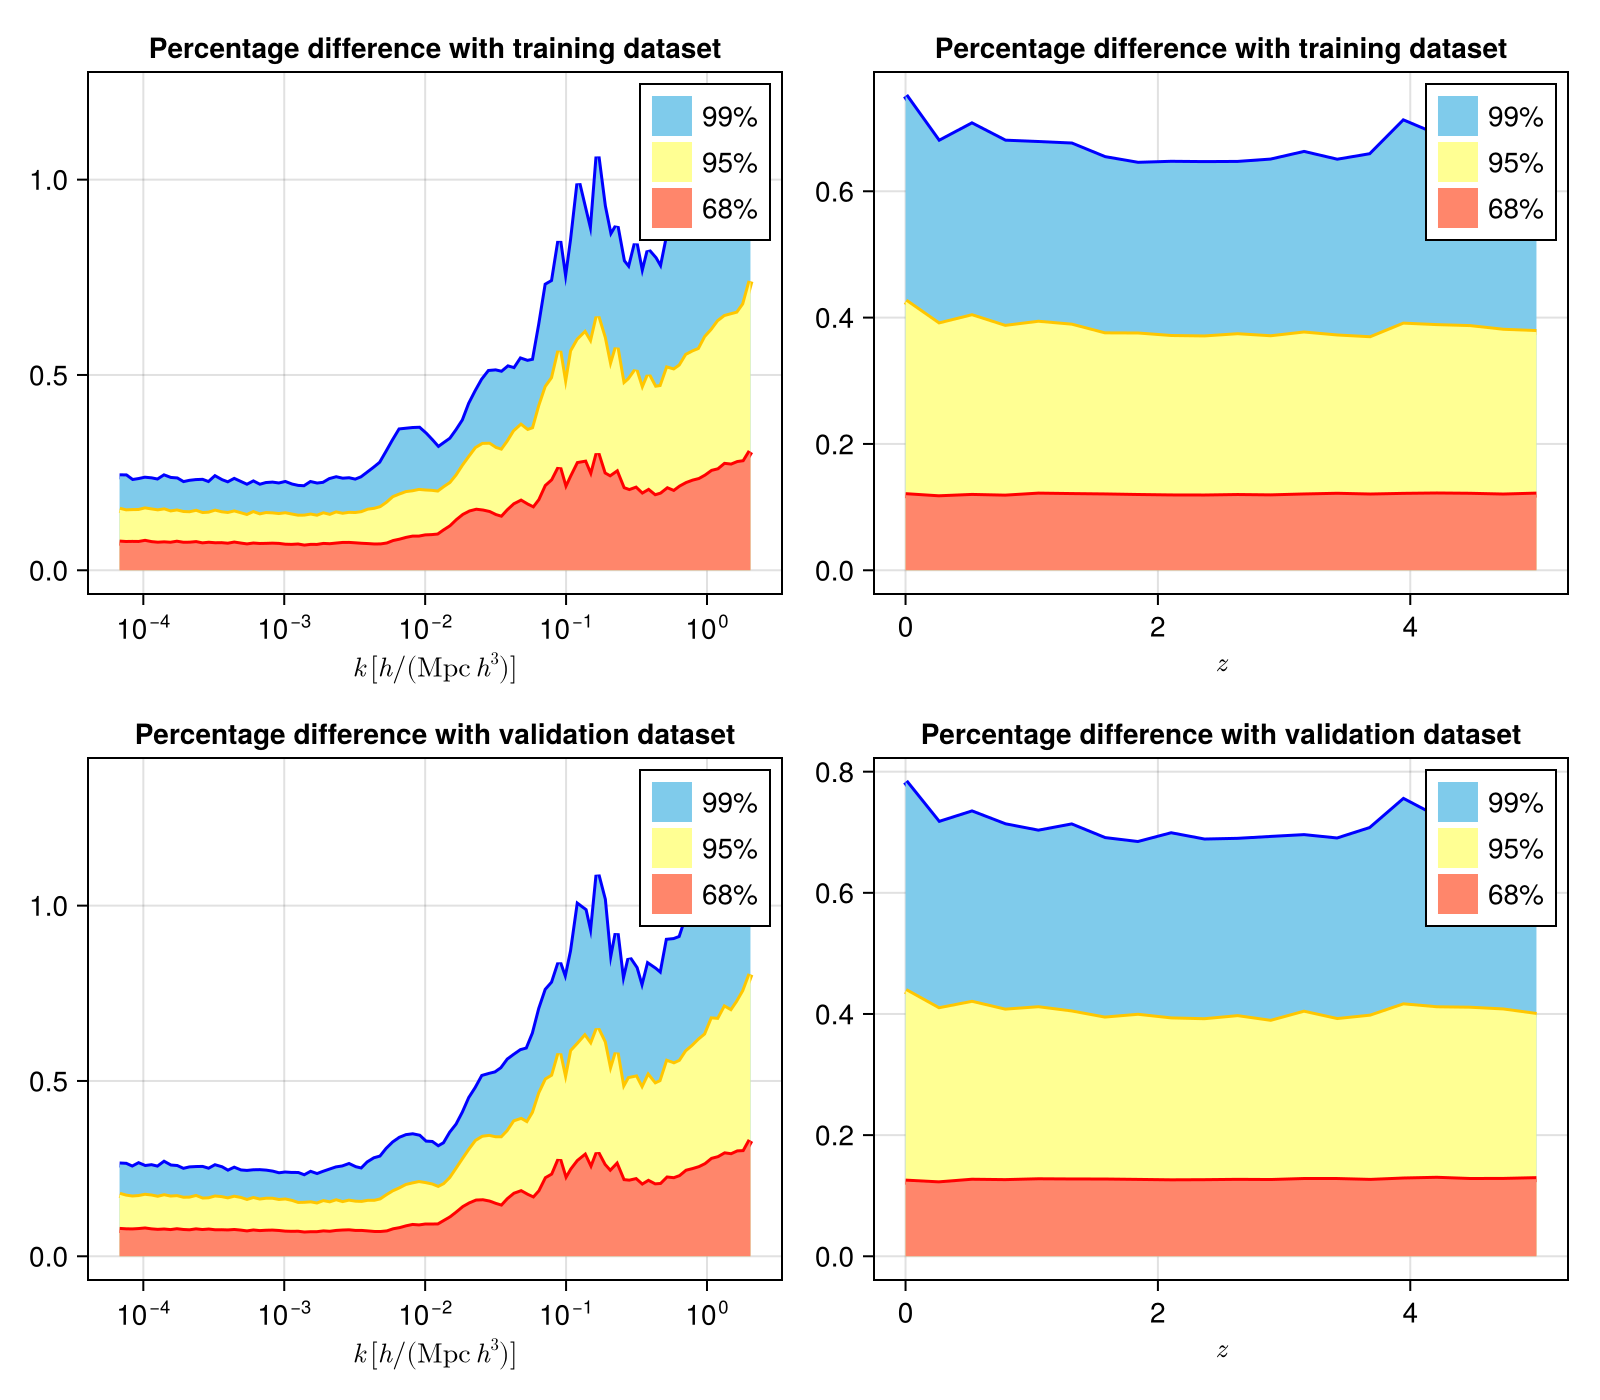

In [11]:
fig = Figure(size = (800, 700))

zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h

xax = [[kk,kk] [zz,zz]]
diffs = [[diffk,diffk_v] [diffz,diffz_v]]


for i in 1:2
    for j in 1:2
        ax = CairoMakie.Axis(fig[i,j])
        
        ind99 = convert(Int, (size(diffs[i,j])[1]/100)*99)
        l99 = lines!(ax, xax[i,j], diffs[i,j][ind99,:], linewidth=3, color=:blue)
        a99 = band!(ax, xax[i,j], 0, diffs[i,j][ind99,:], color="#7FCBEB")

        ind95 = convert(Int, (size(diffs[i,j])[1]/100)*95)
        l95 = lines!(ax, xax[i,j], diffs[i,j][ind95,:], linewidth=3, color=:"#FFC600")
        a95 = band!(ax, xax[i,j], 0, diffs[i,j][ind95,:], color="#FFFF93")

        ind68 = convert(Int, (size(diffs[i,j])[1]/100)*68)
        l68 = lines!(ax, xax[i,j], diffs[i,j][ind68,:], linewidth=3, color=:red)
        a68 = band!(ax, xax[i,j], 0, diffs[i,j][ind68,:], color="#FF866B")

        axislegend(ax, [a99, a95, a68], ["99%", "95%", "68%"])
        
        if i == 1
            ax.title = "Percentage difference with training dataset"
        else
            ax.title = "Percentage difference with validation dataset"
        end

        if j == 1
            ax.xlabel = L"k \, [h/(\mathrm{Mpc} \, h^3)]"
            ax.xscale = log10
        else
            ax.xlabel = L"z"
        end

    end
end

save("../plots/diff_nn_$(cicli)-$(epoche)_$(div).pdf", fig)
return fig


In [12]:
# best validation loss: 3.3552296894440923e-7

## Stessa cosa ma con As e ns liberi

In [13]:
input2 = npzread("../files/train_in_asns_emul_" * string(nc) * ".npy")
output2 = npzread("../files/train_pkz_asns_emul_" * string(nc) * ".npy")
output2 = np.reshape(output2, [nc,nk*nz])'

x2 = input2
y2 = output2

2000×2000 adjoint(::Matrix{Float64}) with eltype Float64:
 92.3789    159.399     627.895     …  213.069     288.137     511.867
 69.1105    118.096     469.163        162.112     217.757     382.515
 52.2161     88.6335    354.184        123.969     165.718     288.785
 40.2017     67.9431    272.553         96.2276    128.215     222.226
 31.6148     53.2807    214.275         76.0873    101.161     174.701
 25.3754     42.6874    171.961     …   61.2951     81.3791    140.192
 20.7483     34.8616    140.595         50.2439     66.6445    114.612
 17.2448     28.952     116.854         41.8332     55.454      95.2493
 14.5396     24.3973     98.5265        35.3151     46.7944     80.3021
 12.4131     20.8217     84.1213        30.1777     39.9764     68.5542
 10.7143     17.9681     72.6147    …   26.0656     34.5234     59.1706
  9.33761    15.657      63.2897        22.7281     30.1        51.5664
  8.20739    13.7607     55.6345        19.9851     26.4659     45.3241
  ⋮          

In [14]:
# standardizzazione del trainig dataset (feature - min(features))/(max(features) - min(features))
min_in2 = minimum(x2, dims=2)
max_in2 = maximum(x2, dims=2)

min_out2 = minimum(y2, dims=2)
max_out2 = maximum(y2, dims=2)

x2 = (x2 .- min_in2) ./ (max_in2 .- min_in2)
y2 = (y2 .- min_out2) ./ (max_out2 .- min_out2)

2000×2000 Matrix{Float64}:
 0.0       0.0322014  0.257302  0.0528607  …  0.0579888  0.0940572  0.201554
 0.0       0.0307353  0.251006  0.0528543     0.0583524  0.093266   0.196641
 0.0       0.0297382  0.246585  0.0528307     0.058593   0.0926852  0.193181
 0.0       0.029088   0.24363   0.0528042     0.0587455  0.0922854  0.19086
 0.0       0.0286661  0.241678  0.0527807     0.0588415  0.0920169  0.189318
 0.0       0.0283889  0.240376  0.0527615  …  0.0589026  0.091837   0.188281
 0.0       0.0282031  0.239493  0.0527461     0.0589419  0.0917155  0.187569
 0.0       0.028076   0.238881  0.0527335     0.0589675  0.0916325  0.187069
 0.0       0.0279873  0.238449  0.0527229     0.0589842  0.0915754  0.186708
 0.0       0.0279244  0.238138  0.0527139     0.058995   0.0915358  0.186441
 0.0       0.0278792  0.23791   0.052706   …  0.0590017  0.0915084  0.186238
 0.0       0.0278465  0.237741  0.0526989     0.0590055  0.0914897  0.186082
 0.0       0.0278228  0.237614  0.0526923     0.05

In [15]:
# carico lo stato allenato della rete

tstate2 = JLD2.load("../models/nn_asns_$(cicli)-$(epoche)_$(div).jld2", "tstate")

# importo validation dataset

valid_in2 = npzread("../files/val_in_asns_emul_" * string(ncv) * ".npy")
valid_in2 = (valid_in2 .- minimum(valid_in2, dims=2)) ./ (maximum(valid_in2, dims=2) .- minimum(valid_in2, dims=2))
valid_out2 = npzread("../files/val_pkz_asns_emul_" * string(ncv) * ".npy")
val_out2 = np.reshape(valid_out2, [ncv,nk*nz])'

2000×1000 adjoint(::Matrix{Float64}) with eltype Float64:
 121.836     804.74       785.055     …  220.785      522.438     514.066
  91.7379    598.764      590.116        167.342      387.668     384.068
  69.63      450.682      447.375        127.614      291.254     289.914
  53.7747    346.118      345.237         98.8702     223.41      223.076
  42.3761    271.743      271.924         78.0781     175.268     175.363
  34.0607    217.877      218.498     …   62.8459     140.455     140.721
  27.8771    178.017      178.796         51.4857     114.722     115.045
  23.1861    147.883      148.693         42.8503      95.2818     95.6113
  19.5591    124.641      125.425         36.1638      80.2951     80.6094
  16.7051    106.385      107.121         30.8971      68.5276     68.8188
  14.4235     91.8092      92.4902    …   26.6834      59.1351     59.401
  12.5733     80.0016      80.6274        23.2646      51.5278     51.7692
  11.0538     70.3113      70.8851        20.4554 

In [16]:
# predizione con training dataset
dev_cpu = cpu_device()
pred_train_iniz2 = dev_cpu(Lux.apply(tstate2.model, x2, tstate2.parameters, tstate2.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_train_st2 = (pred_train_iniz2 .- minimum(pred_train_iniz2, dims=2)) ./ (maximum(pred_train_iniz2, dims=2) .- minimum(pred_train_iniz2, dims=2))

# de-standardizzo la predizione standardizzata
pred_train_st2 = pred_train_st2 .* (max_out2 - min_out2) .+ min_out2

# de-standrdizzo la predizione iniziale
pred_train2 = pred_train_iniz2 .* (max_out2 - min_out2) .+ min_out2

2000×2000 Matrix{Float64}:
 92.6839    158.055     627.427     …  212.236     288.875     509.656
 68.4186    117.356     469.009        161.602     218.09      380.928
 50.7366     87.8055    354.11         123.682     166.136     288.681
 38.8013     67.5588    272.549         95.9547    128.417     222.014
 30.7172     52.8614    214.132         75.8132    101.279     174.729
 24.4395     42.2791    171.923     …   61.2005     81.4378    140.368
 20.1056     34.6058    140.594         50.0226     66.7774    114.642
 16.5899     28.78      116.937         41.6822     55.5506     95.1151
 14.0563     24.2883     98.5441        35.2103     46.8802     80.3054
 12.1555     20.7433     84.076         30.065      40.0486     68.5663
 10.292      17.8812     72.6753    …   26.0233     34.5717     59.1636
  9.06118    15.5688     63.2899        22.6586     30.1175     51.5634
  7.90718    13.6515     55.6609        19.946      26.4951     45.3391
  ⋮                                 ⋱       

In [17]:
# predizione con validation dataset
pred_val_iniz2 = dev_cpu(Lux.apply(tstate2.model, valid_in2, tstate2.parameters, tstate2.states)[1])

# standardizzazione della predizione (y - min(y))/(max(y) - min(y))
pred_val_st2 = (pred_val_iniz2 .- minimum(pred_val_iniz2, dims=2)) ./ (maximum(pred_val_iniz2, dims=2) .- minimum(pred_val_iniz2, dims=2))

# de-standardizzo la predizione standardizzata
pred_val_st2 = pred_val_st2 .* (max_out2 - min_out2) .+ min_out2

# de-standrdizzo la predizione iniziale
pred_val2 = pred_val_iniz2 .* (max_out2 - min_out2) .+ min_out2

2000×1000 Matrix{Float64}:
 120.979     804.948      787.748     …  221.565      523.066     514.759
  91.3922    598.633      591.117        167.249      387.878     384.708
  69.3859    450.964      448.109        128.457      291.326     290.114
  53.6273    346.308      345.478         99.3881     223.606     223.322
  42.264     271.646      272.193         78.0411     175.318     175.601
  34.0847    217.889      218.597     …   63.0521     140.497     140.907
  27.8611    178.06       179.02          51.6092     114.765     115.16
  23.2273    147.915      148.645         42.7882      95.3224     95.7533
  19.5605    124.711      125.447         36.2537      80.3364     80.6935
  16.7018    106.411      107.201         30.8542      68.542      68.8925
  14.4429     91.8569      92.4386    …   26.7312      59.1572     59.4793
  12.604      80.0116      80.6133        23.306       51.5556     51.8459
  11.0785     70.3194      70.859         20.5445      45.2913     45.5586
   ⋮  

In [18]:
# salvo i dati predetti in un array di numpy
np.save("../files/pred_nn_asns_" *string(nc), pred_train2)
np.save("../files/pred_nn_asns_val_" *string(ncv), pred_val2)

In [19]:
# preparo il plot delle differenze percentuali con il training dataset

diffk2 = zeros(Float64, nc*nz, nk)
diffz2 = zeros(Float64, nc*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk2[:,i] = reshape(100*abs.(1 .- pred_train2[start:stop,:] ./ output2[start:stop,:]), nc*nz, 1)
end
diffk2 = sort(diffk2, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz2[:,i] = reshape(100*abs.(1 .- pred_train2[index,:] ./ output2[index,:]), nc*nk, 1)
end
diffz2 = sort(diffz2, dims=1)


200000×20 Matrix{Float64}:
 1.27174e-6  1.93092e-7  4.28972e-7  …  2.57763e-7  1.34538e-6  4.68464e-7
 1.56075e-6  5.0119e-7   2.54056e-6     6.83371e-7  2.88365e-6  8.06643e-7
 2.23586e-6  1.27107e-6  2.54089e-6     1.0953e-6   2.97737e-6  9.44994e-7
 2.6936e-6   1.47932e-6  5.44541e-6     1.1188e-6   4.04317e-6  2.50785e-6
 2.79454e-6  1.97819e-6  6.32109e-6     1.41772e-6  4.20516e-6  2.75604e-6
 3.11901e-6  2.2703e-6   6.48276e-6  …  1.45158e-6  4.92457e-6  3.59907e-6
 3.31786e-6  3.63459e-6  6.80203e-6     2.01405e-6  5.33073e-6  3.65657e-6
 3.43434e-6  4.96128e-6  8.20438e-6     3.07383e-6  6.63344e-6  3.69535e-6
 3.43513e-6  5.30484e-6  9.96978e-6     5.1595e-6   8.23348e-6  3.9291e-6
 4.49267e-6  5.5075e-6   1.02405e-5     5.49589e-6  9.70062e-6  5.57954e-6
 5.63414e-6  5.52797e-6  1.02496e-5  …  5.62942e-6  1.15014e-5  5.8563e-6
 7.84642e-6  5.64774e-6  1.05528e-5     5.86599e-6  1.25924e-5  6.00606e-6
 8.3133e-6   6.48161e-6  1.085e-5       6.23275e-6  1.45811e-5  6.48808e-6


In [20]:
# preparo il plot delle differenze percentuali con il validation dataset

diffk_v2 = zeros(Float64, ncv*nz, nk)
diffz_v2 = zeros(Float64, ncv*nk, nz)

for i in 1:nk
    start = (i-1) * nz + 1
    stop = (i-1) * nz + nz
    diffk_v2[:,i] = reshape(100*abs.(1 .- pred_val2[start:stop,:] ./ val_out2[start:stop,:]), ncv*nz, 1)
end
diffk_v2 = sort(diffk_v2, dims=1)

for i in 1:nz
    index = i:nz:nk*nz
    diffz_v2[:,i] = reshape(100*abs.(1 .- pred_val2[index,:] ./ val_out2[index,:]), ncv*nk, 1)
end
diffz_v2 = sort(diffz_v2, dims=1)

100000×20 Matrix{Float64}:
 1.23689e-8  5.85721e-6  3.7028e-6   …  2.47733e-7  2.01016e-6  6.29178e-6
 3.41949e-6  5.95056e-6  6.28073e-6     4.81401e-6  3.80859e-6  6.53026e-6
 3.60654e-6  6.11461e-6  6.44655e-6     5.61953e-6  4.18424e-6  1.49792e-5
 5.8268e-6   6.92747e-6  6.69398e-6     6.52233e-6  4.73374e-6  1.59785e-5
 1.19203e-5  7.49621e-6  7.00048e-6     7.64465e-6  5.48764e-6  1.61385e-5
 1.32443e-5  7.62913e-6  7.36731e-6  …  8.45973e-6  6.07311e-6  1.96552e-5
 1.48087e-5  7.72686e-6  8.09871e-6     8.68296e-6  6.72221e-6  2.0382e-5
 1.57233e-5  1.22536e-5  9.53842e-6     8.7215e-6   6.89676e-6  2.45497e-5
 1.95741e-5  1.39058e-5  9.99072e-6     8.83311e-6  7.17802e-6  2.57392e-5
 2.09769e-5  1.67566e-5  1.27019e-5     9.30769e-6  7.65969e-6  2.66077e-5
 2.32726e-5  1.69198e-5  1.67371e-5  …  1.25258e-5  9.22247e-6  2.69372e-5
 2.48555e-5  1.76821e-5  1.91324e-5     1.52548e-5  1.56064e-5  3.0467e-5
 2.60344e-5  1.97913e-5  2.08385e-5     1.56903e-5  1.63978e-5  3.11218e-5


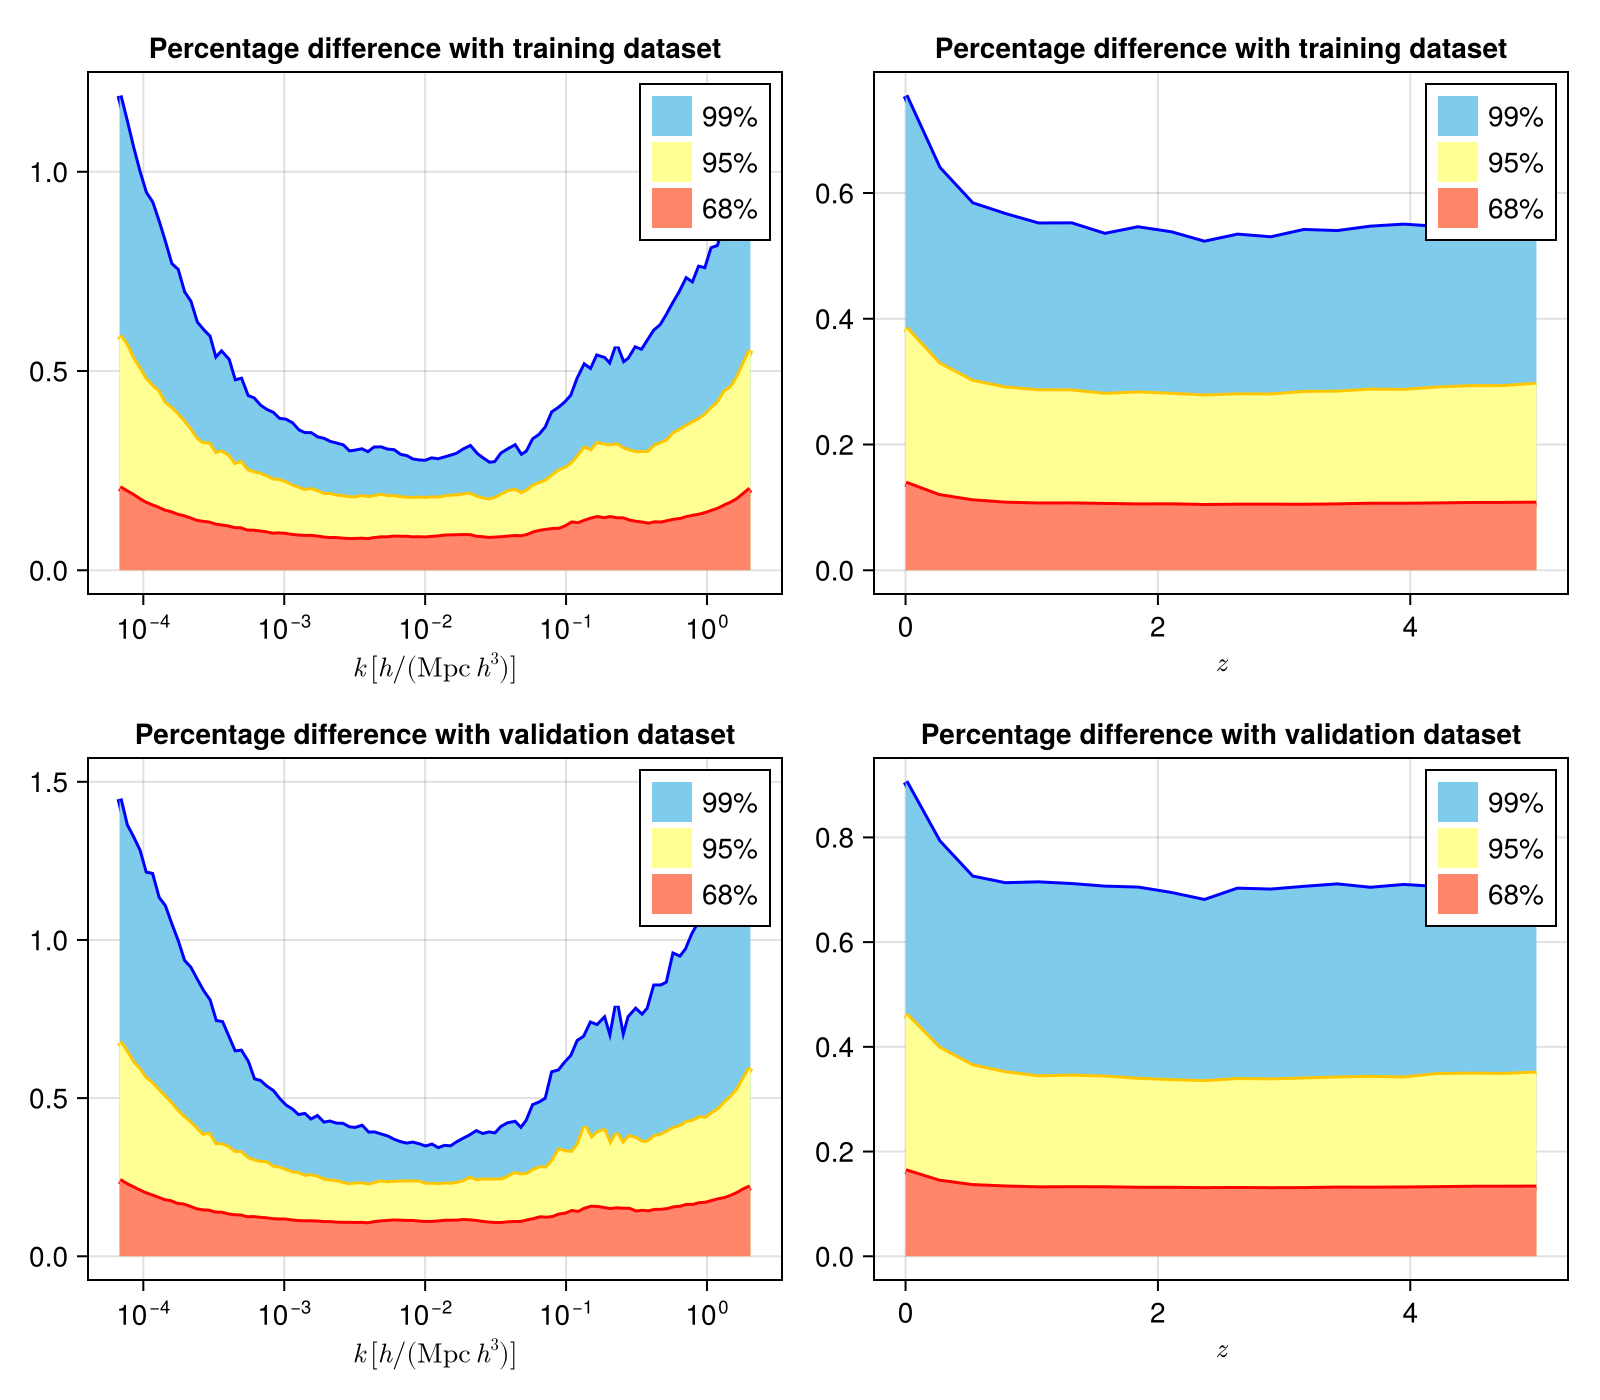

In [21]:
fig = Figure(size = (800, 700))

zz = Float32.(range(0, 5, 20))
h = 0.67810
kk = exp10.(LinRange(-4, log10(3), 100)) .* h

xax = [[kk,kk] [zz,zz]]
diffs2 = [[diffk2,diffk_v2] [diffz2,diffz_v2]]


for i in 1:2
    for j in 1:2
        ax = CairoMakie.Axis(fig[i,j])
        
        ind99 = convert(Int, (size(diffs2[i,j])[1]/100)*99)
        l99 = lines!(ax, xax[i,j], diffs2[i,j][ind99,:], linewidth=3, color=:blue)
        a99 = band!(ax, xax[i,j], 0, diffs2[i,j][ind99,:], color="#7FCBEB")

        ind95 = convert(Int, (size(diffs2[i,j])[1]/100)*95)
        l95 = lines!(ax, xax[i,j], diffs2[i,j][ind95,:], linewidth=3, color=:"#FFC600")
        a95 = band!(ax, xax[i,j], 0, diffs2[i,j][ind95,:], color="#FFFF93")

        ind68 = convert(Int, (size(diffs2[i,j])[1]/100)*68)
        l68 = lines!(ax, xax[i,j], diffs2[i,j][ind68,:], linewidth=3, color=:red)
        a68 = band!(ax, xax[i,j], 0, diffs2[i,j][ind68,:], color="#FF866B")

        axislegend(ax, [a99, a95, a68], ["99%", "95%", "68%"])
        
        if i == 1
            ax.title = "Percentage difference with training dataset"
        else
            ax.title = "Percentage difference with validation dataset"
        end

        if j == 1
            ax.xlabel = L"k \, [h/(\mathrm{Mpc} \, h^3)]"
            ax.xscale = log10
        else
            ax.xlabel = L"z"
        end

    end
end

save("../plots/diff_nn_asns_$(cicli)-$(epoche)_$(div).pdf", fig)
save("../plots/diff_nn_asns_$(cicli)-$(epoche)_$(div).png", fig)

return fig
